# Data Exploration / Testing Algorithms

Dataset: https://snap.stanford.edu/data/soc-RedditHyperlinks.html

Political subreddits list: https://github.com/valentinhofmann/politosphere/blob/main/data/subreddits.txt


## Dataset information
- **SOURCE_SUBREDDIT**: the subreddit where the link originates
- **TARGET_SUBREDDIT**: the subreddit where the link ends
- **POST_ID**: the post in the source subreddit that starts the link
- **TIMESTAMP**: time time of the post
- **POST_LABEL**: label indicating if the source post is explicitly negative towards the target post. The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.
- **POST_PROPERTIES**: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:
1. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER

22-86. LIWC Variables

In [47]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt

In [48]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

In [49]:
clustering_embed = pd.read_csv("data/embedding_clusters.csv")

In [50]:
import re

# Read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]

regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|justice|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)
political_subs = list(set(political_subs))

source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only rows where both source and target are political
df = df_full[source_is_political & target_is_political]

df = df[df['SOURCE_SUBREDDIT'].isin(clustering_embed['subreddit']) &
                        df['TARGET_SUBREDDIT'].isin(clustering_embed['subreddit'])]



In [51]:
df.to_csv("data/filtered_network.csv", index=False)

In [52]:
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.DiGraph(),edge_attr="count")
# convert to adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G, weight="count")

In [53]:

# add link sentiments
df_counts = df.groupby([source, target])['LINK_SENTIMENT'].value_counts().reset_index()
links = df_counts.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT'])['count'].sum().unstack(fill_value=0).reset_index().rename(columns={1: 'POSITIVE', -1: 'NEGATIVE'})
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
edgelist_df["LINK_SENTIMENT"] = edgelist_df["POSITIVE"] - edgelist_df["NEGATIVE"]
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "POSITIVE", "NEGATIVE", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

In [54]:
def best_louvain_partition(G):

    best_modularity = -1
    best_partition = None
    for i in range(50):
        partition = community_louvain.best_partition(G, weight='count', random_state=i)
        modularity_value = community_louvain.modularity(partition, G)
        if modularity_value > best_modularity:
            best_modularity = modularity_value
            best_partition = partition
    return best_partition

partition = best_louvain_partition(G_undirected) 

nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_directed, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

In [55]:
from collections import defaultdict

# Create a dictionary to store nodes for each community
communities = defaultdict(list)

# Populate the dictionary
for node, community in partition.items():
    communities[community].append(node)

# Now, `communities` contains a list of nodes for each community
for community, nodes in communities.items():
    print(f"Community {community}: {nodes}")


Community 0: ['libertarian', 'politics', 'economy', 'politic', 'altnewz', 'worldpolitics', 'badeconomics', 'politicalmoderation', 'badpolitics', 'democrats', 'ncpolitics', 'randpaul', 'censorship', 'ask_politics', 'enoughsandersspam', 'inthenews', 'libertarianmeme', 'potuselection2016', '2016_elections', 'trueprogressive', 'hillaryclinton', 'media_criticism', 'politicalhumor', 'asktrumpsupporters', 'donaldtrump', 'jillstein', 'enoughtrumpspam', 'mr_trump', 'pdx4trump', 'newjerseylibertarians', 'askhillarysupporters', 'donaldtrump2016', 'libertarians', 'political_revolution', 'uncensorednews', 'stillsandersforpres', 'enough_sanders_spam', 'politicalrevolutionca', 'political_discussion', 'electionreform', 'politicalrevolutionfl', '2016elections', 'libertarianpartyohio', 'libertarianpartyusa', 'slatestarcodex', 'abetterworldnews', 'neutralnews', 'the_meltdown', 'politics1', 'idontlikerpolitics', 'calexit', 'thenewcoldwar', 'antitrumpalliance', 'justiceserved', 'trumpforprison', 'antiwar',

In [56]:
df['Louvain_Community_Source'] = df['SOURCE_SUBREDDIT'].map(partition)
df['Louvain_Community_Target'] = df['TARGET_SUBREDDIT'].map(partition)

In [57]:
# Prepare a mapping of subreddits to Louvain communities
louvain_community_mapping = pd.concat([
    df[['SOURCE_SUBREDDIT', 'Louvain_Community_Source']].rename(columns={'SOURCE_SUBREDDIT': 'subreddit', 'Louvain_Community_Source': 'Louvain_Community'}),
    df[['TARGET_SUBREDDIT', 'Louvain_Community_Target']].rename(columns={'TARGET_SUBREDDIT': 'subreddit', 'Louvain_Community_Target': 'Louvain_Community'})
]).drop_duplicates()

# Merge Louvain community and embedding clusters
merged = pd.merge(clustering_embed, louvain_community_mapping, on='subreddit', how='inner')


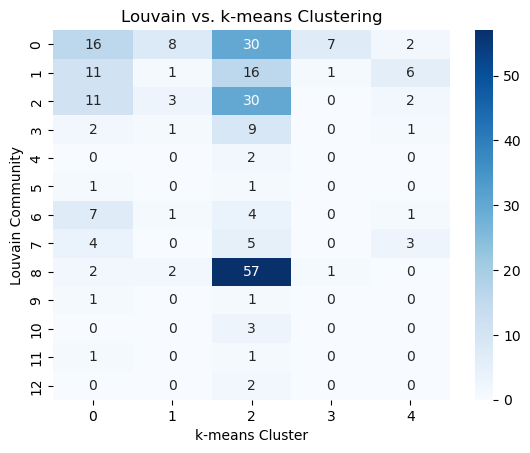

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create contingency table
contingency_table = pd.crosstab(merged['Louvain_Community'], merged['Cluster'])

# Visualize it as a heatmap
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues")
plt.title("Louvain vs. k-means Clustering")
plt.xlabel("k-means Cluster")
plt.ylabel("Louvain Community")
plt.show()


In [59]:
from sklearn.metrics import adjusted_rand_score

# Compute ARI
ari = adjusted_rand_score(merged['Louvain_Community'], merged['Cluster'])
print(f"Adjusted Rand Index: {ari}")

from sklearn.metrics import normalized_mutual_info_score

# Compute NMI
nmi = normalized_mutual_info_score(merged['Louvain_Community'], merged['Cluster'])
print(f"Normalized Mutual Information: {nmi}")


Adjusted Rand Index: 0.05615209919015728
Normalized Mutual Information: 0.10971542897013471


In [60]:
from itertools import combinations
import pandas as pd

# Initialize results
same_cluster_same_community = []
same_cluster_different_community = []

# Group by cluster
for cluster_id, group in merged.groupby('Cluster'):
    subreddits = group['subreddit'].tolist()
    communities = group['Louvain_Community'].tolist()

    # Generate all pairs within the cluster
    for (subreddit1, community1), (subreddit2, community2) in combinations(zip(subreddits, communities), 2):
        if community1 == community2:
            same_cluster_same_community.append((subreddit1, subreddit2))
        else:
            same_cluster_different_community.append((subreddit1, subreddit2))

# Calculate statistics
total_pairs = len(same_cluster_same_community) + len(same_cluster_different_community)
same_community_percentage = len(same_cluster_same_community) / total_pairs * 100
print(f"Percentage of pairs in the same cluster that are also in the same community: {same_community_percentage:.2f}%")

# Example of mismatched pairs
print("Examples of subreddits in the same cluster but different communities:")
print(same_cluster_different_community[:5])


Percentage of pairs in the same cluster that are also in the same community: 20.26%
Examples of subreddits in the same cluster but different communities:
[('geopolitics', 'unfilter'), ('geopolitics', 'enoughlibertarianspam'), ('geopolitics', 'jillstein'), ('geopolitics', 'abetterworldnews'), ('geopolitics', 'progun')]


In [61]:
# In-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
print("In-degree centrality:", in_degree_centrality)

# Out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)
print("Out-degree centrality:", out_degree_centrality)

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness centrality:", betweenness_centrality)


In-degree centrality: {'libertarian': 0.06640625, 'conservative': 0.1015625, 'communism101': 0.01953125, 'communism': 0.0234375, 'mensrightsmeta': 0.00390625, 'mensrights': 0.02734375, 'politicaldiscussion': 0.125, 'politics': 0.2734375, 'socialism': 0.1015625, 'postnationalist': 0.00390625, 'enoughlibertarianspam': 0.01953125, 'liberal': 0.01953125, 'law': 0.0078125, 'libertariandebates': 0.00390625, 'economy': 0.0078125, 'politic': 0.01953125, 'mmt_economics': 0.0, 'ronpaul': 0.00390625, 'socialistprogrammers': 0.0, 'new_right': 0.00390625, 'progun': 0.0234375, 'climateskeptics': 0.0, 'askaconservative': 0.01171875, 'alltheleft': 0.0, 'republican': 0.03125, 'altnewz': 0.00390625, 'agitation': 0.0, 'worldpolitics': 0.03515625, 'againstmensrights': 0.01953125, 'badeconomics': 0.04296875, 'prolife': 0.00390625, 'progressive': 0.0234375, 'metanarchism': 0.015625, 'prochoice': 0.00390625, 'geopolitics': 0.03515625, 'whiterights': 0.015625, 'syriancivilwar': 0.06640625, 'politicalmoderatio

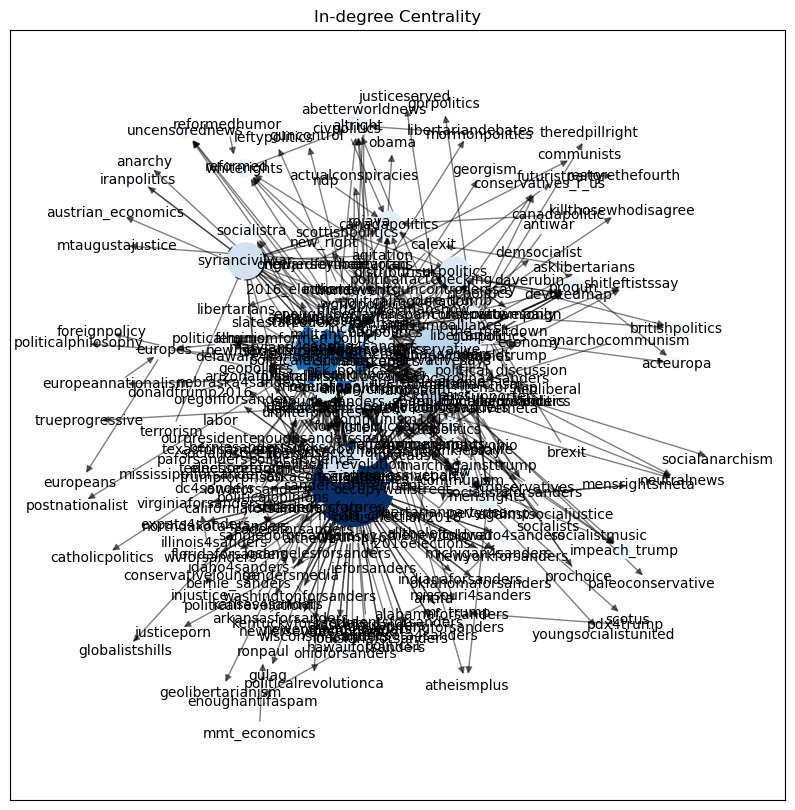

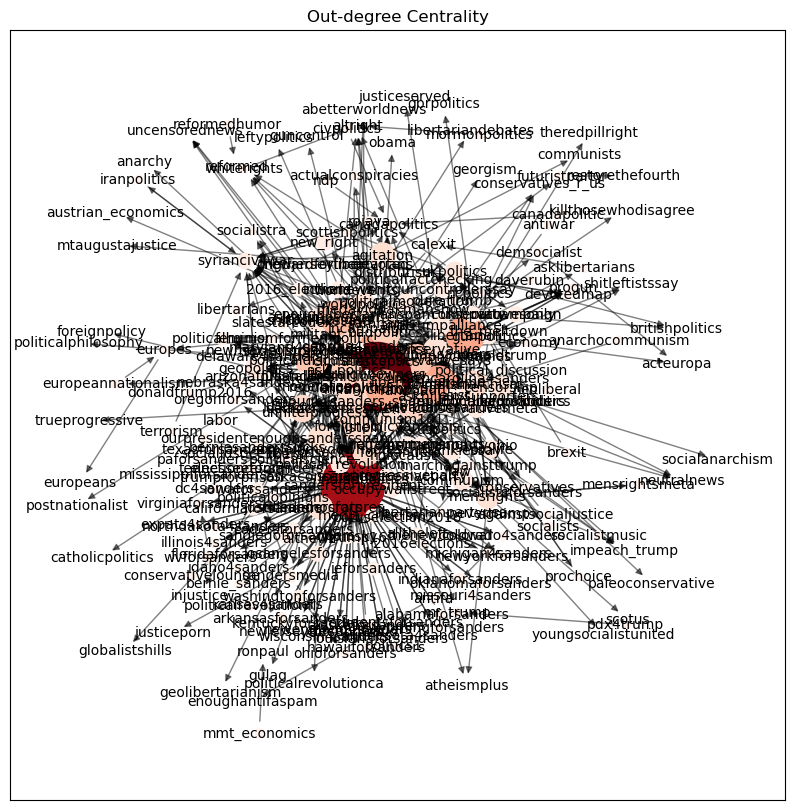

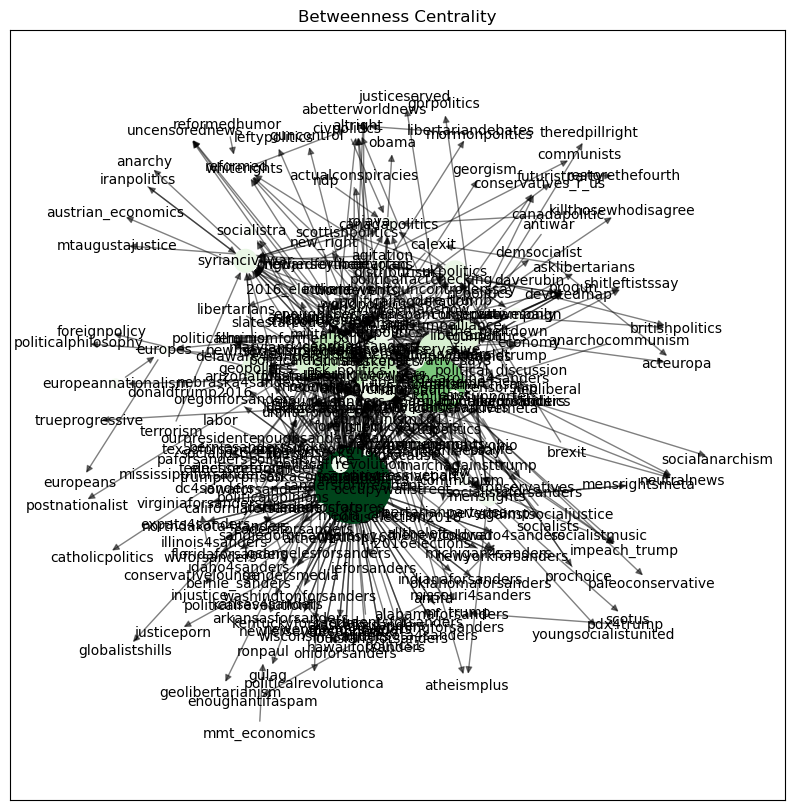

In [62]:
import matplotlib.pyplot as plt

# Set node sizes based on centrality
node_size = [v * 10000 for v in in_degree_centrality.values()]  
node_color = [v for v in in_degree_centrality.values()] 

# Visualizing the graph with In-degree centrality
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, iterations=20)  
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('In-degree Centrality')
plt.show()

# Out-degree centrality visualization
node_size = [v * 10000 for v in out_degree_centrality.values()]
node_color = [v for v in out_degree_centrality.values()]
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Reds)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Out-degree Centrality')
plt.show()

# Betweenness centrality visualization
node_size = [v * 10000 for v in betweenness_centrality.values()]
node_color = [v for v in betweenness_centrality.values()]
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title('Betweenness Centrality')
plt.show()


In [63]:
betweenness = nx.betweenness_centrality(G_undirected, weight="count")
top_betweenness_nodes = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:", top_betweenness_nodes)


Top 10 nodes by betweenness centrality: [('sandersforpresident', 0.3400093189050661), ('politics', 0.19331999134137914), ('shitliberalssay', 0.1507761781859407), ('conservative', 0.1442159349900792), ('socialism', 0.10900131033976616), ('politicaldiscussion', 0.08532932297495996), ('syriancivilwar', 0.0687626812364651), ('badeconomics', 0.0653613917846053), ('libertarian', 0.06371146019200229), ('esist', 0.04618266126102489)]


In [64]:
graph_density = nx.density(G_undirected)
print(f"Graph Density: {graph_density}")

for community, nodes in communities.items():
    subgraph = G_undirected.subgraph(nodes)
    community_density = nx.density(subgraph)
    print(f"Community {community} Density: {community_density}")


Graph Density: 0.01848249027237354


AttributeError: 'list' object has no attribute 'items'

In [ ]:
edge_overlap = defaultdict(int)

for node in G_undirected.nodes():
    community = partition[node]
    for neighbor in G_undirected.neighbors(node):
        neighbor_community = partition[neighbor]
        if community != neighbor_community:
            edge_overlap[(community, neighbor_community)] += 1

print("Edge Overlap Between Communities:", dict(edge_overlap))


Edge Overlap Between Communities: {(0, 4): 15, (0, 10): 4, (0, 5): 26, (0, 2): 18, (2, 0): 18, (2, 5): 37, (2, 4): 17, (2, 11): 4, (2, 10): 6, (2, 15): 5, (4, 5): 49, (4, 2): 17, (4, 11): 6, (4, 10): 6, (4, 0): 15, (4, 15): 3, (5, 0): 26, (5, 2): 37, (5, 4): 49, (5, 10): 33, (5, 15): 17, (5, 11): 8, (4, 16): 1, (0, 15): 1, (11, 4): 6, (11, 2): 4, (11, 0): 1, (11, 5): 8, (15, 2): 5, (15, 5): 17, (15, 0): 1, (15, 11): 1, (15, 4): 3, (11, 15): 1, (0, 11): 1, (10, 0): 4, (10, 2): 6, (10, 4): 6, (10, 5): 33, (10, 15): 2, (15, 10): 2, (16, 4): 1}


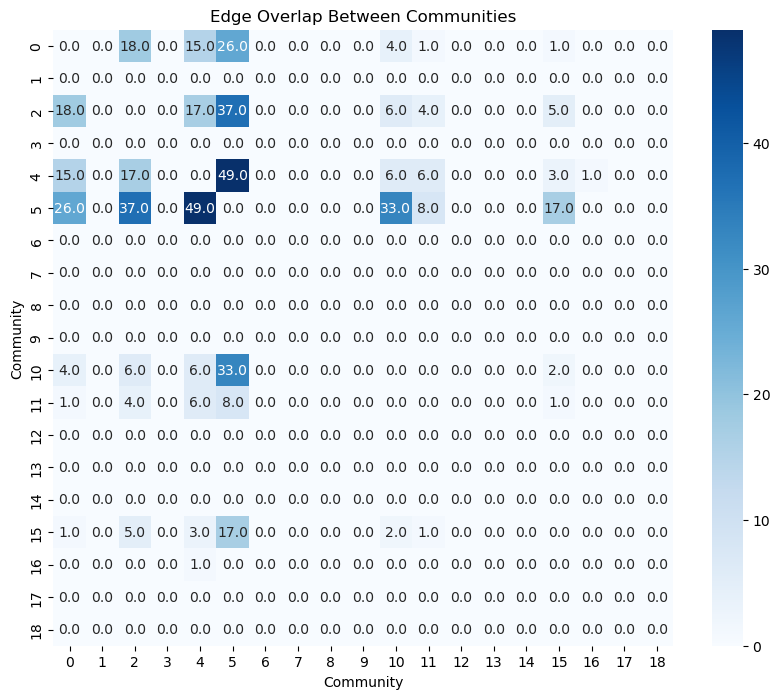

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a dictionary of community pairs and their overlap
max_community = max(partition.values()) + 1  

# Create an empty overlap matrix
overlap_matrix = np.zeros((max_community, max_community))

# Populate the matrix with the edge overlap data
for (community1, community2), overlap_count in edge_overlap.items():
    overlap_matrix[community1, community2] = overlap_count
    overlap_matrix[community2, community1] = overlap_count  

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, annot=True, fmt=".1f", cmap="Blues", xticklabels=range(max_community), yticklabels=range(max_community))
plt.title("Edge Overlap Between Communities")
plt.xlabel("Community")
plt.ylabel("Community")
plt.show()


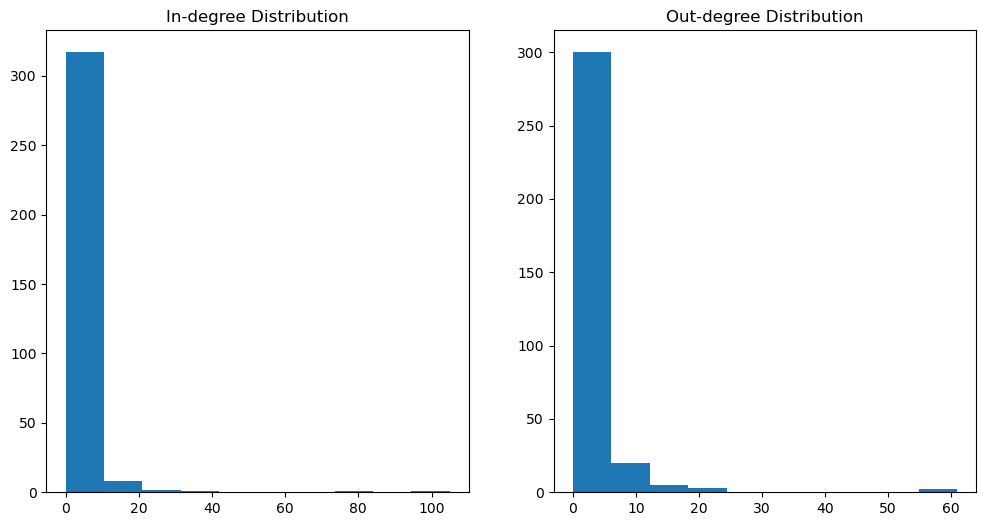

In [ ]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Plot In-degree and Out-degree distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(in_degrees.values())
plt.title("In-degree Distribution")

plt.subplot(1, 2, 2)
plt.hist(out_degrees.values())
plt.title("Out-degree Distribution")
plt.show()
